# Thevenin equivalent circuit {#sec-thevenin}
Last update: 30 Jan 2024  

## Introduction
The Thevenin equivalent circuit is the reduction of a linear one port circuit to a single source and impedance and is based on [Thevenin’s Theorem](https://en.wikipedia.org/wiki/Th%C3%A9venin%27s_theorem). This notebook describes solving problem 11.25, given in chapter 11 of @Johnson1978. The Python libraries of SimPy and NumPy are used to perform the math in the proposed solution. The problem asks the student to replace the circuit to the left of terminals a-b by its Thevenin equivalent and find V. The schematic was drawn using LTspice and the nodes were numbered. Terminals a-b are across the resistor R3. The circuit given in the textbook does not include a reference node, however the node at the bottom of the schematic was chosen as the reference node, ground. 

![Circuit for problem 11.25 of @Johnson1978](problem_11-25.PNG){#fig-problem_11-25}  

Having drawn the circuit in LTspice, the following netlist was exported as a text file.  
```
R1 2 0 6
R2 3 2 6
R3 0 3 6
L1 2 0 j2
L2 1 3 j3
C1 1 2 -j3
C2 3 0 -j2
I1 0 1 -1-j1
```

The component values for the inductors and capacitors are complex as well as the value of the current source. It is assumed that the impedance of the inductors and capacitors are at a frequency of 1 radian per second. So accordingly, the values in the net list used by the Python code to generate the network equations has been adjusted as follows:  
```
R1 2 0 6
R2 3 2 6
R3 0 3 6
L1 2 0 2
L2 1 3 3
C1 1 2 0.33
C2 3 0 0.5
I1 0 1 1
```
The component values are not used when the symbolic network equations are generated, only the reference designators, R1, C1, L1 etc. are used.  

In [43]:
#import os
from sympy import *
import numpy as np
from tabulate import tabulate
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

## Find the open circuit voltage, Voc
Removing R3 and C2 from the netlist, this gives Voc = V3. The net list is:  
```
I1 0 1 1
R1 2 0 6
R2 3 2 6
*R3 0 3 6
L1 2 0 2
L2 1 3 3
C1 1 2 0.33
*C2 3 0 0.5
```

Load the net list

In [44]:
net_list = '''
I1 0 1 1
R1 2 0 6
R2 3 2 6
*R3 0 3 6
L1 2 0 2
L2 1 3 3
C1 1 2 0.3333333333
*C2 3 0 0.5
'''

Call the symbolic modified nodal analysis function

In [45]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

Display the equations

In [46]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

$C_{1} s v_{1} - C_{1} s v_{2} + I_{L2} = I_{1}$<br>$- C_{1} s v_{1} + I_{L1} + v_{2} \left(C_{1} s + \frac{1}{R_{2}} + \frac{1}{R_{1}}\right) - \frac{v_{3}}{R_{2}} = 0$<br>$- I_{L2} - \frac{v_{2}}{R_{2}} + \frac{v_{3}}{R_{2}} = 0$<br>$- I_{L1} L_{1} s + v_{2} = 0$<br>$- I_{L2} L_{2} s + v_{1} - v_{3} = 0$<br>

Build the network equation matrix

In [47]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)
NE_sym

⎡         C₁⋅s⋅v₁ - C₁⋅s⋅v₂ + I_L2         ⎤       
⎢                                          ⎥       
⎢                     ⎛       1    1 ⎞   v₃⎥   ⎡I₁⎤
⎢-C₁⋅s⋅v₁ + I_L1 + v₂⋅⎜C₁⋅s + ── + ──⎟ - ──⎥   ⎢  ⎥
⎢                     ⎝       R₂   R₁⎠   R₂⎥   ⎢0 ⎥
⎢                                          ⎥   ⎢  ⎥
⎢                     v₂   v₃              ⎥ = ⎢0 ⎥
⎢             -I_L2 - ── + ──              ⎥   ⎢  ⎥
⎢                     R₂   R₂              ⎥   ⎢0 ⎥
⎢                                          ⎥   ⎢  ⎥
⎢             -I_L1⋅L₁⋅s + v₂              ⎥   ⎣0 ⎦
⎢                                          ⎥       
⎣           -I_L2⋅L₂⋅s + v₁ - v₃           ⎦       

In [48]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

Generate the symbolic solution

In [49]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [50]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = \frac{C_{1} I_{1} L_{1} L_{2} R_{1} s^{3} + C_{1} I_{1} L_{1} R_{1} R_{2} s^{2} + I_{1} L_{1} L_{2} s^{2} + I_{1} L_{1} R_{1} s + I_{1} L_{1} R_{2} s + I_{1} L_{2} R_{1} s + I_{1} R_{1} R_{2}}{C_{1} L_{1} L_{2} s^{3} + C_{1} L_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} s^{2} + C_{1} R_{1} R_{2} s + L_{1} s + R_{1}}$<br>$v_{2} = \frac{I_{1} L_{1} R_{1} s}{L_{1} s + R_{1}}$<br>$v_{3} = \frac{C_{1} I_{1} L_{1} L_{2} R_{1} s^{3} + C_{1} I_{1} L_{1} R_{1} R_{2} s^{2} + I_{1} L_{1} R_{1} s + I_{1} L_{1} R_{2} s + I_{1} R_{1} R_{2}}{C_{1} L_{1} L_{2} s^{3} + C_{1} L_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} s^{2} + C_{1} R_{1} R_{2} s + L_{1} s + R_{1}}$<br>$I_{L1} = \frac{I_{1} R_{1}}{L_{1} s + R_{1}}$<br>$I_{L2} = \frac{I_{1}}{C_{1} L_{2} s^{2} + C_{1} R_{2} s + 1}$<br>

Construct a dictionary of element values

In [51]:
element_values = SymMNA.get_part_values(network_df)
element_values

To solve numerically, replace symbols with the element values and the Laplace variable, s,  with $j\omega$ where $\omega=1$.

In [52]:
#NE = NE_sym.subs({L1:2, L2:3, R1:6, R2:6, C1:1/3, I1:-1-1j, s:1j})
NE = NE_sym.subs({s:1j,I1:-1-1j})
NE = NE.subs(element_values)
NE

⎡                      I_L2 + 0.3333333333⋅ⅈ⋅v₁ - 0.3333333333⋅ⅈ⋅v₂           
⎢                                                                             
⎢I_L1 - 0.3333333333⋅ⅈ⋅v₁ + v₂⋅(0.333333333333333 + 0.3333333333⋅ⅈ) - 0.166666
⎢                                                                             
⎢                   -I_L2 - 0.166666666666667⋅v₂ + 0.166666666666667⋅v₃       
⎢                                                                             
⎢                                    -2.0⋅ⅈ⋅I_L1 + v₂                         
⎢                                                                             
⎣                                  -3.0⋅ⅈ⋅I_L2 + v₁ - v₃                      

            ⎤   ⎡-1.0 - ⅈ⎤
            ⎥   ⎢        ⎥
666666667⋅v₃⎥   ⎢   0    ⎥
            ⎥   ⎢        ⎥
            ⎥ = ⎢   0    ⎥
            ⎥   ⎢        ⎥
            ⎥   ⎢   0    ⎥
            ⎥   ⎢        ⎥
            ⎦   ⎣   0    ⎦

Solving the system of equations for the open circuit voltage at node v3.

In [53]:
Voc = solve(NE,X)[v3]
Voc

## Find the short circuit current, Isc
Remove C2 and R3, set node 3 to zero, find current in L2 and R2.  New net list:

```
I1 0 1 1
R1 2 0 6
R2 0 2 6
L1 2 0 2
L2 1 0 3
C1 1 2 0.33
```

In [54]:
net_list = '''
I1 0 1 1
R1 2 0 6
R2 0 2 6
L1 2 0 2
L2 1 0 3
C1 1 2 0.33333333333333
'''

Call the symbolic modified nodal analysis function

In [55]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

Display the equations

In [56]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

$C_{1} s v_{1} - C_{1} s v_{2} + I_{L2} = I_{1}$<br>$- C_{1} s v_{1} + I_{L1} + v_{2} \left(C_{1} s + \frac{1}{R_{2}} + \frac{1}{R_{1}}\right) = 0$<br>$- I_{L1} L_{1} s + v_{2} = 0$<br>$- I_{L2} L_{2} s + v_{1} = 0$<br>

Build the network equation matrix

In [57]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)
NE_sym

⎡      C₁⋅s⋅v₁ - C₁⋅s⋅v₂ + I_L2       ⎤       
⎢                                     ⎥   ⎡I₁⎤
⎢                     ⎛       1    1 ⎞⎥   ⎢  ⎥
⎢-C₁⋅s⋅v₁ + I_L1 + v₂⋅⎜C₁⋅s + ── + ──⎟⎥   ⎢0 ⎥
⎢                     ⎝       R₂   R₁⎠⎥ = ⎢  ⎥
⎢                                     ⎥   ⎢0 ⎥
⎢           -I_L1⋅L₁⋅s + v₂           ⎥   ⎢  ⎥
⎢                                     ⎥   ⎣0 ⎦
⎣           -I_L2⋅L₂⋅s + v₁           ⎦       

In [58]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

Symbolic solution

In [59]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [60]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = \frac{C_{1} I_{1} L_{1} L_{2} R_{1} R_{2} s^{3} + I_{1} L_{1} L_{2} R_{1} s^{2} + I_{1} L_{1} L_{2} R_{2} s^{2} + I_{1} L_{2} R_{1} R_{2} s}{C_{1} L_{1} L_{2} R_{1} s^{3} + C_{1} L_{1} L_{2} R_{2} s^{3} + C_{1} L_{1} R_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} R_{2} s^{2} + L_{1} R_{1} s + L_{1} R_{2} s + R_{1} R_{2}}$<br>$v_{2} = \frac{C_{1} I_{1} L_{1} L_{2} R_{1} R_{2} s^{3}}{C_{1} L_{1} L_{2} R_{1} s^{3} + C_{1} L_{1} L_{2} R_{2} s^{3} + C_{1} L_{1} R_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} R_{2} s^{2} + L_{1} R_{1} s + L_{1} R_{2} s + R_{1} R_{2}}$<br>$I_{L1} = \frac{C_{1} I_{1} L_{2} R_{1} R_{2} s^{2}}{C_{1} L_{1} L_{2} R_{1} s^{3} + C_{1} L_{1} L_{2} R_{2} s^{3} + C_{1} L_{1} R_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} R_{2} s^{2} + L_{1} R_{1} s + L_{1} R_{2} s + R_{1} R_{2}}$<br>$I_{L2} = \frac{C_{1} I_{1} L_{1} R_{1} R_{2} s^{2} + I_{1} L_{1} R_{1} s + I_{1} L_{1} R_{2} s + I_{1} R_{1} R_{2}}{C_{1} L_{1} L_{2} R_{1} s^{3} + C_{1} L_{1} L_{2} R_{2} s^{3} + C_{1} L_{1} R_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} R_{2} s^{2} + L_{1} R_{1} s + L_{1} R_{2} s + R_{1} R_{2}}$<br>

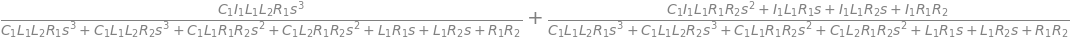

In [61]:
U_sym[v2]/R2 + U_sym[I_L2]

Construct a dictionary of element values

In [62]:
element_values = SymMNA.get_part_values(network_df)
element_values

In [63]:
#NE = NE_sym.subs({L1:2, L2:3, R1:6, R2:6, C1:1/3, I1:-1-1j, s:1j})
NE = NE_sym.subs({s:1j,I1:-1-1j})
NE = NE.subs(element_values)
NE

⎡           I_L2 + 0.33333333333333⋅ⅈ⋅v₁ - 0.33333333333333⋅ⅈ⋅v₂           ⎤  
⎢                                                                          ⎥  
⎢I_L1 - 0.33333333333333⋅ⅈ⋅v₁ + v₂⋅(0.333333333333333 + 0.33333333333333⋅ⅈ)⎥  
⎢                                                                          ⎥ =
⎢                             -2.0⋅ⅈ⋅I_L1 + v₂                             ⎥  
⎢                                                                          ⎥  
⎣                             -3.0⋅ⅈ⋅I_L2 + v₁                             ⎦  

 ⎡-1.0 - ⅈ⎤
 ⎢        ⎥
 ⎢   0    ⎥
 ⎢        ⎥
 ⎢   0    ⎥
 ⎢        ⎥
 ⎣   0    ⎦

In [64]:
U = solve(NE,X)
U

In [65]:
Isc = U[v2]/6 + U[I_L2]
Isc

In [66]:
Zth = simplify(Voc/Isc)
Zth

Current in I_R2 = V2/R2

In [67]:
Isc = U[v2]/6 + U[I_L2]
Isc

In [68]:
Zth = simplify(Voc/Isc)
Zth

Voc along with Zth are the values to the Thevenin equivalent circuit.

## Find V3 using the Thevenin equivalent circuit
The load attached to the Thevenin equivalent circuit is the parallel of the resistor and capacitor.  
$Z = \frac{1}{\frac{1}{R}+\frac{1}{C}}$  
The load $Z$ is the parallel combination of R = 6 and C = -j2.

In [69]:
Z = (1)/(1/(6)+1/(-2j))
Z

(0.6-1.7999999999999998j)

Using the values for $V_{oc}$ and $Z_{th}$ obtained above, we write the equation for V3 as a voltage divider and have SymPy simplify the result.

In [70]:
simplify(Z*Voc/(Zth+Z))

We can get SymPy to ignore small numbers by using the round function set to 3 digits.

In [71]:
simplify(Z*Voc/(Zth+Z)).round(3)

## Find V3 using the complete circuit
Checking the answer for V3, by solving the equations for the complete circuit. The net list is: 
```
I1 0 1 1
R1 2 0 6
R2 3 2 6
R3 0 3 6
L1 2 0 2
L2 1 3 3
C1 1 2 0.33
C2 3 0 0.5
```

Declare the symbols and equations for the complete circuit.

In [72]:
net_list = '''
I1 0 1 1
R1 2 0 6
R2 3 2 6
R3 0 3 6
L1 2 0 2
L2 1 3 3
C1 1 2 0.333333333333333
C2 3 0 0.5
'''

Call the symbolic modified nodal analysis function

In [73]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

Display the equations

In [74]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

$C_{1} s v_{1} - C_{1} s v_{2} + I_{L2} = I_{1}$<br>$- C_{1} s v_{1} + I_{L1} + v_{2} \left(C_{1} s + \frac{1}{R_{2}} + \frac{1}{R_{1}}\right) - \frac{v_{3}}{R_{2}} = 0$<br>$- I_{L2} + v_{3} \left(C_{2} s + \frac{1}{R_{3}} + \frac{1}{R_{2}}\right) - \frac{v_{2}}{R_{2}} = 0$<br>$- I_{L1} L_{1} s + v_{2} = 0$<br>$- I_{L2} L_{2} s + v_{1} - v_{3} = 0$<br>

Build the network equation matrix

In [75]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)
NE_sym

⎡         C₁⋅s⋅v₁ - C₁⋅s⋅v₂ + I_L2         ⎤       
⎢                                          ⎥       
⎢                     ⎛       1    1 ⎞   v₃⎥   ⎡I₁⎤
⎢-C₁⋅s⋅v₁ + I_L1 + v₂⋅⎜C₁⋅s + ── + ──⎟ - ──⎥   ⎢  ⎥
⎢                     ⎝       R₂   R₁⎠   R₂⎥   ⎢0 ⎥
⎢                                          ⎥   ⎢  ⎥
⎢                ⎛       1    1 ⎞   v₂     ⎥ = ⎢0 ⎥
⎢     -I_L2 + v₃⋅⎜C₂⋅s + ── + ──⎟ - ──     ⎥   ⎢  ⎥
⎢                ⎝       R₃   R₂⎠   R₂     ⎥   ⎢0 ⎥
⎢                                          ⎥   ⎢  ⎥
⎢             -I_L1⋅L₁⋅s + v₂              ⎥   ⎣0 ⎦
⎢                                          ⎥       
⎣           -I_L2⋅L₂⋅s + v₁ - v₃           ⎦       

In [76]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

Symbolic solution

In [77]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [78]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = \frac{C_{1} C_{2} I_{1} L_{1} L_{2} R_{1} R_{2} R_{3} s^{4} + C_{1} I_{1} L_{1} L_{2} R_{1} R_{2} s^{3} + C_{1} I_{1} L_{1} L_{2} R_{1} R_{3} s^{3} + C_{1} I_{1} L_{1} R_{1} R_{2} R_{3} s^{2} + C_{2} I_{1} L_{1} L_{2} R_{1} R_{3} s^{3} + C_{2} I_{1} L_{1} L_{2} R_{2} R_{3} s^{3} + C_{2} I_{1} L_{2} R_{1} R_{2} R_{3} s^{2} + I_{1} L_{1} L_{2} R_{1} s^{2} + I_{1} L_{1} L_{2} R_{2} s^{2} + I_{1} L_{1} L_{2} R_{3} s^{2} + I_{1} L_{1} R_{1} R_{3} s + I_{1} L_{1} R_{2} R_{3} s + I_{1} L_{2} R_{1} R_{2} s + I_{1} L_{2} R_{1} R_{3} s + I_{1} R_{1} R_{2} R_{3}}{C_{1} C_{2} L_{1} L_{2} R_{1} R_{3} s^{4} + C_{1} C_{2} L_{1} L_{2} R_{2} R_{3} s^{4} + C_{1} C_{2} L_{1} R_{1} R_{2} R_{3} s^{3} + C_{1} C_{2} L_{2} R_{1} R_{2} R_{3} s^{3} + C_{1} L_{1} L_{2} R_{1} s^{3} + C_{1} L_{1} L_{2} R_{2} s^{3} + C_{1} L_{1} L_{2} R_{3} s^{3} + C_{1} L_{1} R_{1} R_{2} s^{2} + C_{1} L_{1} R_{2} R_{3} s^{2} + C_{1} L_{2} R_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} R_{3} s^{2} + C_{1} R_{1} R_{2} R_{3} s + C_{2} L_{1} R_{1} R_{3} s^{2} + C_{2} L_{1} R_{2} R_{3} s^{2} + C_{2} R_{1} R_{2} R_{3} s + L_{1} R_{1} s + L_{1} R_{2} s + L_{1} R_{3} s + R_{1} R_{2} + R_{1} R_{3}}$<br>$v_{2} = \frac{C_{1} C_{2} I_{1} L_{1} L_{2} R_{1} R_{2} R_{3} s^{4} + C_{1} I_{1} L_{1} L_{2} R_{1} R_{2} s^{3} + C_{1} I_{1} L_{1} L_{2} R_{1} R_{3} s^{3} + C_{1} I_{1} L_{1} R_{1} R_{2} R_{3} s^{2} + I_{1} L_{1} R_{1} R_{3} s}{C_{1} C_{2} L_{1} L_{2} R_{1} R_{3} s^{4} + C_{1} C_{2} L_{1} L_{2} R_{2} R_{3} s^{4} + C_{1} C_{2} L_{1} R_{1} R_{2} R_{3} s^{3} + C_{1} C_{2} L_{2} R_{1} R_{2} R_{3} s^{3} + C_{1} L_{1} L_{2} R_{1} s^{3} + C_{1} L_{1} L_{2} R_{2} s^{3} + C_{1} L_{1} L_{2} R_{3} s^{3} + C_{1} L_{1} R_{1} R_{2} s^{2} + C_{1} L_{1} R_{2} R_{3} s^{2} + C_{1} L_{2} R_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} R_{3} s^{2} + C_{1} R_{1} R_{2} R_{3} s + C_{2} L_{1} R_{1} R_{3} s^{2} + C_{2} L_{1} R_{2} R_{3} s^{2} + C_{2} R_{1} R_{2} R_{3} s + L_{1} R_{1} s + L_{1} R_{2} s + L_{1} R_{3} s + R_{1} R_{2} + R_{1} R_{3}}$<br>$v_{3} = \frac{C_{1} I_{1} L_{1} L_{2} R_{1} R_{3} s^{3} + C_{1} I_{1} L_{1} R_{1} R_{2} R_{3} s^{2} + I_{1} L_{1} R_{1} R_{3} s + I_{1} L_{1} R_{2} R_{3} s + I_{1} R_{1} R_{2} R_{3}}{C_{1} C_{2} L_{1} L_{2} R_{1} R_{3} s^{4} + C_{1} C_{2} L_{1} L_{2} R_{2} R_{3} s^{4} + C_{1} C_{2} L_{1} R_{1} R_{2} R_{3} s^{3} + C_{1} C_{2} L_{2} R_{1} R_{2} R_{3} s^{3} + C_{1} L_{1} L_{2} R_{1} s^{3} + C_{1} L_{1} L_{2} R_{2} s^{3} + C_{1} L_{1} L_{2} R_{3} s^{3} + C_{1} L_{1} R_{1} R_{2} s^{2} + C_{1} L_{1} R_{2} R_{3} s^{2} + C_{1} L_{2} R_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} R_{3} s^{2} + C_{1} R_{1} R_{2} R_{3} s + C_{2} L_{1} R_{1} R_{3} s^{2} + C_{2} L_{1} R_{2} R_{3} s^{2} + C_{2} R_{1} R_{2} R_{3} s + L_{1} R_{1} s + L_{1} R_{2} s + L_{1} R_{3} s + R_{1} R_{2} + R_{1} R_{3}}$<br>$I_{L1} = \frac{C_{1} C_{2} I_{1} L_{2} R_{1} R_{2} R_{3} s^{3} + C_{1} I_{1} L_{2} R_{1} R_{2} s^{2} + C_{1} I_{1} L_{2} R_{1} R_{3} s^{2} + C_{1} I_{1} R_{1} R_{2} R_{3} s + I_{1} R_{1} R_{3}}{C_{1} C_{2} L_{1} L_{2} R_{1} R_{3} s^{4} + C_{1} C_{2} L_{1} L_{2} R_{2} R_{3} s^{4} + C_{1} C_{2} L_{1} R_{1} R_{2} R_{3} s^{3} + C_{1} C_{2} L_{2} R_{1} R_{2} R_{3} s^{3} + C_{1} L_{1} L_{2} R_{1} s^{3} + C_{1} L_{1} L_{2} R_{2} s^{3} + C_{1} L_{1} L_{2} R_{3} s^{3} + C_{1} L_{1} R_{1} R_{2} s^{2} + C_{1} L_{1} R_{2} R_{3} s^{2} + C_{1} L_{2} R_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} R_{3} s^{2} + C_{1} R_{1} R_{2} R_{3} s + C_{2} L_{1} R_{1} R_{3} s^{2} + C_{2} L_{1} R_{2} R_{3} s^{2} + C_{2} R_{1} R_{2} R_{3} s + L_{1} R_{1} s + L_{1} R_{2} s + L_{1} R_{3} s + R_{1} R_{2} + R_{1} R_{3}}$<br>$I_{L2} = \frac{C_{1} C_{2} I_{1} L_{1} R_{1} R_{2} R_{3} s^{3} + C_{1} I_{1} L_{1} R_{1} R_{2} s^{2} + C_{2} I_{1} L_{1} R_{1} R_{3} s^{2} + C_{2} I_{1} L_{1} R_{2} R_{3} s^{2} + C_{2} I_{1} R_{1} R_{2} R_{3} s + I_{1} L_{1} R_{1} s + I_{1} L_{1} R_{2} s + I_{1} L_{1} R_{3} s + I_{1} R_{1} R_{2} + I_{1} R_{1} R_{3}}{C_{1} C_{2} L_{1} L_{2} R_{1} R_{3} s^{4} + C_{1} C_{2} L_{1} L_{2} R_{2} R_{3} s^{4} + C_{1} C_{2} L_{1} R_{1} R_{2} R_{3} s^{3} + C_{1} C_{2} L_{2} R_{1} R_{2} R_{3} s^{3} + C_{1} L_{1} L_{2} R_{1} s^{3} + C_{1} L_{1} L_{2} R_{2} s^{3} + C_{1} L_{1} L_{2} R_{3} s^{3} + C_{1} L_{1} R_{1} R_{2} s^{2} + C_{1} L_{1} R_{2} R_{3} s^{2} + C_{1} L_{2} R_{1} R_{2} s^{2} + C_{1} L_{2} R_{1} R_{3} s^{2} + C_{1} R_{1} R_{2} R_{3} s + C_{2} L_{1} R_{1} R_{3} s^{2} + C_{2} L_{1} R_{2} R_{3} s^{2} + C_{2} R_{1} R_{2} R_{3} s + L_{1} R_{1} s + L_{1} R_{2} s + L_{1} R_{3} s + R_{1} R_{2} + R_{1} R_{3}}$<br>

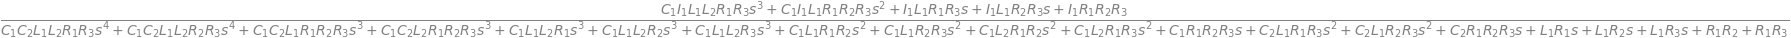

In [79]:
U_sym[v3]

Construct a dictionary of element values

In [80]:
element_values = SymMNA.get_part_values(network_df)
element_values

In [81]:
#NE = NE_sym.subs({L1:2, L2:3, R1:6, R2:6, C1:1/3, I1:-1-1j, s:1j})
NE = NE_sym.subs({s:1j,I1:-1-1j})
NE = NE.subs(element_values)
NE

⎡                      I_L2 + 0.333333333333333⋅ⅈ⋅v₁ - 0.333333333333333⋅ⅈ⋅v₂ 
⎢                                                                             
⎢I_L1 - 0.333333333333333⋅ⅈ⋅v₁ + v₂⋅(0.333333333333333 + 0.333333333333333⋅ⅈ) 
⎢                                                                             
⎢                   -I_L2 - 0.166666666666667⋅v₂ + v₃⋅(0.333333333333333 + 0.5
⎢                                                                             
⎢                                         -2.0⋅ⅈ⋅I_L1 + v₂                    
⎢                                                                             
⎣                                       -3.0⋅ⅈ⋅I_L2 + v₁ - v₃                 

                      ⎤   ⎡-1.0 - ⅈ⎤
                      ⎥   ⎢        ⎥
- 0.166666666666667⋅v₃⎥   ⎢   0    ⎥
                      ⎥   ⎢        ⎥
⋅ⅈ)                   ⎥ = ⎢   0    ⎥
                      ⎥   ⎢        ⎥
                      ⎥   ⎢   0    ⎥
                      ⎥   ⎢  

Solving the system of equations for v3 using the SymPy solve function.

In [82]:
U = solve(NE,X)
U[v3]

The value obtained by solving the system equations for the complete network agrees with the Thevenin equivalent circuit solution. 